In [124]:
import time
import numpy as np
import pandas as pd
import cmath
from pyomo.opt import SolverFactory
from pyomo.environ import *

n = 10; max_tries = None; r_w = 500;
primary='max'; primary_tol=0.001;
secondary_frac=1;
min_range=1e-5;
enforce_range=True;
report_interval=0.1;
quiet=False

report = lambda s: print(s)

if secondary_frac >= 1.0:
    n_secondary = secondary_frac
else:
    n_secondary = np.floor(secondary_frac * len(fva)).astype(int)
    
idxs = (fva.maximum - fva.minimum >= min_range).to_numpy().nonzero()[0]
weights = (1/(fva.maximum - fva.minimum)**2).to_numpy()
report("Targeting {}/{} unblocked primary variables.".format(len(idxs), len(fva)))
report("Targeting {} secondary variables.".format(n_secondary))

report_header, report_format = _make_report_header(n)
report("\n" + report_header)
if report_interval < 1.0:
    report_interval = np.floor(report_interval * n).astype(int)

samples = np.zeros((r_w, len(fva)))
i_samples = np.zeros((n, len(fva)))

k = 0
infeasible_count = 0
counter = 0
true_s = 0

primary_var = -1
try_ = 0
start_time = time.time()

while True:
    if max_tries is not None and try_ >= max_tries:
        break
    try_ += 1
    
    relative, target, width = _maxgap(samples[0:k,idxs], fva.iloc[idxs,:])
    
    primary_var = np.argmax(width)
    
#     if counter >= 2:
#         primary_var = np.random.choice(len(idxs), 1).astype(int)[0]
#         counter = 0     
#     else:
#         primary_var = np.argmax(width)
    
#     primary_var += 1
#     if primary_var >= len(idxs):
#         primary_var = 0

    primary_target = target[primary_var]
    primary_lb = primary_target - primary_tol*width[primary_var]
    primary_ub = primary_target + primary_tol*width[primary_var]
    secondary_vars = np.random.choice(len(idxs), n_secondary, replace=False)


#     temp = np.argpartition(-width, n_secondary)
#     secondary_vars = temp[:n_secondary]

#     temp = np.partition(-width, n_secondary)
#     result = -temp[:n_secondary]
    
    secondary_targets = target[secondary_vars]
    secondary_weights = weights[idxs[secondary_vars]]

    new_sample =  _generate_sample(
                idxs[primary_var], primary_lb, primary_ub,
                idxs[secondary_vars], secondary_targets, secondary_weights)


    if new_sample is not None:
        if enforce_range:
            new_sample[new_sample > fva.maximum] = fva.maximum[new_sample > fva.maximum]
            new_sample[new_sample < fva.minimum] = fva.minimum[new_sample < fva.minimum]

        samples[k,:] = new_sample
        i_samples[true_s,:] = new_sample
    
    
        k += 1
        true_s += 1
        
        if k % report_interval == 0:
            elapsed = time.time() - start_time
            remaining = elapsed / k * (n - k)
            report(report_format.format(
                    i=k, n=n, cov=100*(1-np.mean(relative)),
                    min=np.min(relative), med=np.median(relative),
                    max=np.max(relative), ela=elapsed, rem=remaining,
                    inf=infeasible_count))
    else:
#         addition for infeasible samples
        samples[k,primary_var] = target[primary_var]
        w = idxs
        w = np.delete(w,idxs[primary_var])
        for i in range(len(w)):
            samples[k,w[i]] = fva['minimum'][w[i]]
        k += 1
        
        infeasible_count += 1
        counter += 1
           

    if true_s >= n: break
#     if k >= r_w: break

if true_s < n:
    # max_tries reached; return fewer than n samples
    i_samples = i_samples[:true_s,:]

if k < r_w:
    # max_tries reached; return fewer than n samples
    samples = samples[:k,:]

ans = pd.DataFrame(data=samples,columns=fva.maximum.index)
t_ans = pd.DataFrame(data=i_samples,columns=fva.maximum.index)

Targeting 6/6 unblocked primary variables.
Targeting 1 secondary variables.

Sample   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible
  1/10      0.00%   1.0000   1.0000   1.0000        0.16          1.40            0
  2/10     31.88%   0.5010   0.7126   0.7961        0.26          1.05            0
  3/10     39.64%   0.3989   0.6064   0.7794        0.35          0.83            0
    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
  5/10     57.65%   0.3297   0.4067   0.5546        0.79          0.79            1
  6/10     58.61%   0.3297   0.3974   0.5546        0.90          0.60            1
  7/10     63.69%   0.2133   0.3595   0.5546        1.01          0.43            1
  8/10     64.64%   0.2133   0.3559   0.5546        1.11          0.28            1
  9/10     67.47%   0.1879   0.3030   0.5546        1.24          0.14            1
    model=unknown;
        

In [17]:
writer = pd.ExcelWriter('samples.xlsx')
ans.to_excel(writer,'raw')
writer.save()

In [394]:
relative, target, width = _maxgap(i_samples[0:k,idxs], fva.iloc[idxs,:])
#Coverage
100*(1-np.mean(relative))


64.49392102880694

In [126]:
ans

,P1,P2,P3,Q1,Q2,Q3
0,1.121727,1.223768,0.747814,-0.001999,0.592221,-0.341551
1,1.169921,1.197814,0.737263,0.789779,-0.202298,-0.318919
2,1.584961,0.998974,0.520308,-0.093139,0.011781,0.340528
3,0.500000,0.375000,1.273907,-1.000000,-1.000000,-1.000000
4,1.211788,1.447149,0.450000,-0.545663,0.165598,0.624184
5,1.518956,1.065125,0.523801,0.552855,-0.601145,0.325182
6,1.129325,1.268603,0.700095,0.282832,0.617557,-0.670117
7,1.068338,1.299676,0.708022,0.069140,0.049605,0.003774
8,1.819895,0.686989,0.604727,-0.038935,0.332250,-0.014703
9,0.784169,0.375000,0.450000,-1.000000,-1.000000,-1.000000


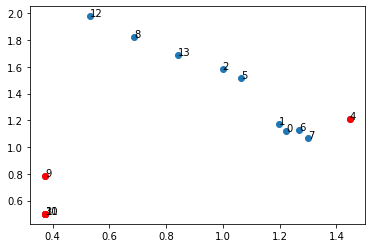

In [125]:
import matplotlib.pyplot as plt
fs_idx = ans[(ans.P1 != 0.5) & (ans.P2 != 0.375) & (ans.P3 != 0.45)].index.to_numpy()
fig, ax = plt.subplots()
ax.scatter(ans['P2'].to_numpy(),ans['P1'].to_numpy())
for i,txt in enumerate(ans.index.to_numpy()):
    if (np.all(i != fs_idx)):
        ax.scatter(ans['P2'].to_numpy()[i], ans['P1'].to_numpy()[i], color='r')
        ax.annotate(txt, (ans['P2'].to_numpy()[i], ans['P1'].to_numpy()[i]) )
    else:
        ax.annotate(txt,(ans['P2'].to_numpy()[i],ans['P1'].to_numpy()[i]))


In [11]:
t_ans

,P1,P2,P3,Q1,Q2,Q3
0,1.572177,0.954200,0.572197,-6.503477e-07,0.234402,0.003358
1,1.536730,1.012796,0.554297,4.999997e-01,-0.382796,0.148091
2,1.277547,1.191556,0.626590,9.910919e-02,0.626290,-0.498313
3,1.170940,1.266943,0.652247,-4.990003e-01,0.426581,0.232124
4,1.544200,1.142763,0.468910,-9.999999e-01,0.761754,0.615294


In [26]:
#Many samples
ans[(ans.P1 != 0.5) & (ans.P2 != 0.375) & (ans.P3 != 0.45)]

array([0, 1, 4, 5, 6], dtype=int64)

In [ ]:
t_ans = pd.DataFrame(data=i_samples,columns=fva.maximum.index)
t_ans = t_ans.to_numpy()
t_ans.sort(0)

k = 0 
gaps[:,k]/(points[-1,:] - points[0,:])[k]

In [75]:
ans

,P1,P2,P3,Q1,Q2,Q3,V1,V2,V3,V4,V5,V6
0,1.250014,1.229304,0.607413,0.015239,0.192970,-0.013368,1.038627,1.031177,1.011953,0.999663,0.991019,0.992149
1,1.715736,0.802153,0.587971,-0.039880,0.304022,-0.003523,1.042140,1.028121,1.009960,1.000244,0.990225,0.990120
2,1.534103,0.997074,0.572031,0.507614,-0.268847,0.026769,1.060362,1.000977,0.990963,0.987078,0.977298,0.969156
3,1.522769,1.070137,0.516419,0.572292,-0.634420,0.344108,1.060589,0.991669,1.012374,0.982166,0.981915,0.979166
4,1.545238,0.962577,0.597995,0.056187,0.713640,-0.506675,1.056122,1.044292,0.975210,1.013128,0.987104,0.974541


In [453]:
ans #with primary

,P1,P2,P3
0,1.251500,1.088610,0.742505
1,1.627405,0.732519,0.737823
2,1.068915,1.293894,0.713680
3,1.819886,0.554117,0.735759
4,1.456357,0.910920,0.747203


In [456]:
ans #without primary

,P1,P2,P3
0,1.246731,1.109920,0.750791
1,1.628916,0.749167,0.744268
2,1.100442,1.245110,0.745901
3,1.081087,1.255541,0.743216
4,1.080951,1.255713,0.743157


In [4]:
def _make_report_header(maxN):
    """Return the header and format string for reporting coverage."""
    nw = len(str(maxN))
    frac_width = 2*nw + 1  # width of 300/1000
    frac_header = 'Sample'
    frac_format = '{i:' + str(nw) + 'd}/{n:' + str(nw) + 'd}'
    if frac_width < len(frac_header):
        pad = ''.join([' ' for _ in range(len(frac_header) - frac_width)])
        frac_format = pad + frac_format
    elif len(frac_header) < frac_width:
        pad = ''.join([' ' for _ in range(frac_width - len(frac_header))])
        frac_header = pad + frac_header
    hdr = frac_header + "   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible"
    fmt = frac_format + "    {cov:6.2f}%   {min:6.4f}   {med:6.4f}   {max:6.4f}   {ela:9.2f}     {rem:9.2f}   {inf:10d}"
    return hdr, fmt

def _maxgap(points, fva=None):
    # points has rows = samples, columns = variables

    # make a copy because we're going to sort the columns
    points = points.copy()
    if fva is not None:
        points = np.vstack((fva.minimum, points, fva.maximum))
    points.sort(0)

    gaps = points[1:,:] - points[0:-1,:]
    width = gaps.max(0)
    loc = gaps.argmax(0)
    left = np.zeros(width.size)
    for i in range(width.size):
        left[i] = points[loc[i],i]
    relative = width / (points[-1,:] - points[0,:])
    target = left + width/2

    return relative, target, width



In [5]:
#load data
xls = pd.ExcelFile('data\case6.xlsx')
branch = pd.read_excel(xls, 'branch')
gen = pd.read_excel(xls, 'gen')
bus = pd.read_excel(xls, 'bus')
cost = pd.read_excel(xls, 'cost')
base = 100  

#Y matrix
base = 100
bus_len = bus.shape[0]
gen_len = len(gen['bus'].ravel())

Ybus = np.matrix(np.zeros([bus_len,bus_len]),dtype=complex)
shunt = np.zeros(bus_len, dtype=complex)
x = [pd.DataFrame() for i in range(bus_len)]
for i in range(bus_len):  
    x[i] = branch.loc[branch['fbus'] == i]
    fro = [j for j in x[i]['tbus']]
    fro = pd.DataFrame(fro)
    for j in range(len(fro)):
        Ybus[i-1,fro.loc[j][0]-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        Ybus[fro.loc[j][0]-1,i-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        shunt[j] = complex(0,sum(x[i]['b'])/2)

for i in range(bus_len):
    Ybus[i,i] = np.sum(Ybus[i,:])*(-1) + complex(0,sum(branch.loc[(branch['fbus']==i+1) | (branch['tbus']==i+1)]['b'])/2)


# declare variables
Pd = np.zeros(bus_len)
Qd = np.zeros(bus_len)
Vmax = np.zeros(bus_len)
Vmin = np.zeros(bus_len)
Pmax = np.zeros(bus_len)
Pmin = np.zeros(bus_len)
Qmax = np.zeros(bus_len)
Qmin = np.zeros(bus_len)
cost_lin = np.zeros(bus_len)
cost_quad = np.zeros(bus_len)

for i in range(bus_len):
    Pd[i] = bus['Pd'][i]/base
    Qd[i] = bus['Qd'][i]/base
    Vmax[i] = bus['Vmax'][i]
    Vmin[i] = bus['Vmin'][i]

for i in range(gen_len):
    k = i
    i = gen['bus'].ravel()[i]
    Pmax[i-1] = gen.loc[gen['bus'] == i]['Pmax'].ravel()[0]/base
    Pmin[i-1] = gen.loc[gen['bus'] == i]['Pmin'].ravel()[0]/base
    Qmax[i-1] = gen.loc[gen['bus'] == i]['Qmax'].ravel()[0]/base
    Qmin[i-1] = gen.loc[gen['bus'] == i]['Qmin'].ravel()[0]/base
    cost_lin[i-1] = cost['lin'][k]*base
    cost_quad[i-1] = cost['quad'][k]*base**2

p = pd.DataFrame([gen['Pmin'],gen['Pmax']]).T
p.columns = ['minimum', 'maximum']
p = p.T
p.columns = ['P1','P2','P3']
p = p.T/base

q = pd.DataFrame([gen['Qmin'],gen['Qmax']]).T
q.columns = ['minimum', 'maximum']
q = q.T
q.columns = ['Q1','Q2','Q3']
q = q.T/base

v = pd.DataFrame([bus['Vmin'],bus['Vmax']]).T
v.columns = ['minimum', 'maximum']
v = v.T
v.columns = ['V1','V2','V3','V4','V5','V6']
v = v.T

frames = [p,q,v]
# fva = pd.concat(frames)
# fva = p
fva = pd.concat([p,q])

In [69]:
# with P, Q, and V
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.t = Var(range(bus_len))

    model.vars = Var(range(len(fva)))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(gen_len):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
        model.c.add(expr = model.vars[i+gen_len] <= fva.iloc[i+gen_len]['maximum'])
        model.c.add(expr = model.vars[i+gen_len] >= fva.iloc[i+gen_len]['minimum'])
        
    for i in range(bus_len):
        model.c.add(expr = model.vars[i+(2*gen_len)] <= fva.iloc[i+(2*gen_len)]['maximum'])
        model.c.add(expr = model.vars[i+(2*gen_len)] >= fva.iloc[i+(2*gen_len)]['minimum'])        

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
#         for i, sec in enumerate(secondary_vars):
#             quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
                holder2 = model.vars[count+gen_len]
                count = count+1
            else:
                holder1 = 0
                holder2 = 0

            model.c.add(expr = sum([model.vars[i+(2*gen_len)]*model.vars[j+(2*gen_len)]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 + Pd[i]== 0)
            model.c.add(expr = sum([model.vars[i+(2*gen_len)]*model.vars[j+(2*gen_len)]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder2 + Qd[i]== 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.vars[x+(2*gen_len)]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.vars[x+(2*gen_len)]*model.vars[y+(2*gen_len)]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.vars[x+(2*gen_len)]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.vars[x+(2*gen_len)]*model.vars[y+(2*gen_len)]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.vars[y+(2*gen_len)]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.vars[x+(2*gen_len)]*model.vars[y+(2*gen_len)]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.vars[y+(2*gen_len)]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.vars[x+(2*gen_len)]*model.vars[y+(2*gen_len)]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 0)

    solution = SolverFactory('ipopt').solve(model)

    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result
    #     print(result)

    elif (solution.solver.status == SolverStatus.error):
        # Do something when model in infeasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
    #     print("Error")
        return None

    elif (solution.solver.termination_condition == TerminationCondition.infeasible):
        # Do something when model in infeasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
    #     print("Error")
        return None
    else:
        # Something else is wrong
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
    #     print("Error")
        return None

In [6]:
# with P and Q
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.t = Var(range(bus_len))
    model.v = Var(range(bus_len))

    model.vars = Var(range(len(fva)))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(gen_len):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
        model.c.add(expr = model.vars[i+gen_len] <= fva.iloc[i+gen_len]['maximum'])
        model.c.add(expr = model.vars[i+gen_len] >= fva.iloc[i+gen_len]['minimum'])
    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
                holder2 = model.vars[count+gen_len]
                count = count+1
            else:
                holder1 = 0
                holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 + Pd[i]== 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder2 + Qd[i]== 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 0)

    solution = SolverFactory('ipopt').solve(model)

    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result
    #     print(result)

    elif (solution.solver.status == SolverStatus.error):
        # Do something when model in infeasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
    #     print("Error")
        return None

    elif (solution.solver.termination_condition == TerminationCondition.infeasible):
        # Do something when model in infeasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
    #     print("Error")
        return None
    else:
        # Something else is wrong
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
    #     print("Error")
        return None

In [380]:
# Only Pg
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.t = Var(range(bus_len))
    model.v = Var(range(bus_len),within=NonNegativeReals, bounds=(Vmin[0],Vmax[0]), initialize=1.0)
    model.Qg = Var(range(bus_len))
    model.vars = Var(range(len(fva)))
    
    
#     model.vars[primary_var].setlb(primary_lb)
#     model.vars[primary_var].setub(primary_ub)
    
    for i in range(bus_len):
        model.Qg[i].fix(0) 

    for i in range(gen_len):
        model.Qg[gen['bus'][i]-1].fixed = False

    

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(gen_len):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
        
    for i in range(bus_len):
        model.c.add(expr = model.Qg[i] <= Qmax[i])
        model.c.add(expr = model.Qg[i] >= Qmin[i])
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
#                 holder2 = model.vars[count+gen_len]
                count = count+1
            else:
                holder1 = 0
#                 holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 + Pd[i]== 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - model.Qg[i] + Qd[i]== 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 0)

    solution = SolverFactory('ipopt').solve(model)

    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result
    #     print(result)

    elif (solution.solver.status == SolverStatus.error):
        # Do something when model in infeasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
    #     print("Error")
        return None

    elif (solution.solver.termination_condition == TerminationCondition.infeasible):
        # Do something when model in infeasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
    #     print("Error")
        return None
    else:
        # Something else is wrong
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
    #     print("Error")
        return None

In [483]:
### Understanding the max gap function
def _maxgap(points, fva=None):
    # points has rows = samples, columns = variables

    # make a copy because we're going to sort the columns
    points = points.copy()
    if fva is not None:
        points = np.vstack((fva.minimum, points, fva.maximum))
    points.sort(0)

    gaps = points[1:,:] - points[0:-1,:]
    width = gaps.max(0)
    loc = gaps.argmax(0)
    left = np.zeros(width.size)
    for i in range(width.size):
        left[i] = points[loc[i],i]
    relative = width / (points[-1,:] - points[0,:])
    target = left + width/2

    return relative, target, width



In [13]:
_generate_sample(
                idxs[primary_var], primary_lb, primary_ub,
                idxs[secondary_vars], secondary_targets, secondary_weights)

array([ 1.40677362,  0.9465703 ,  0.74037483,  0.07209668,  0.45470544,
       -0.29563574,  1.04150469,  1.02817013,  0.98416441,  0.99774345,
        0.97999871,  0.97409107])

In [574]:
width[np.argsort(width)[-2:]]

array([0.87177963, 1.07120376])

In [302]:
ans = ans[(ans.P1 != 0.5) & (ans.P2 != 0.375) & (ans.P3 != 0.45)]

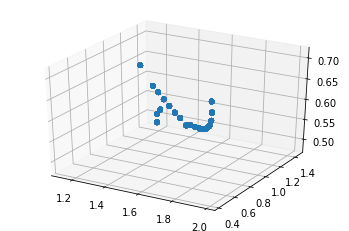

In [305]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

xx = ans['P1'].to_numpy()
yy = ans['P2'].to_numpy()
zz = ans['P3'].to_numpy()

x = np.outer(xx, np.ones(100))
y = np.outer(yy, np.ones(100))
z = np.outer(zz, np.ones(100))

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(x, y, z)
#ax.set_title('Surface plot')
plt.show()

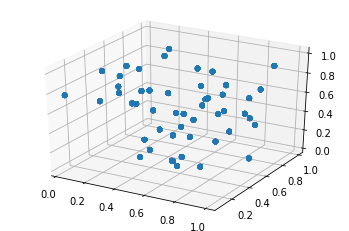

In [599]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

n = 100

xx = np.random.uniform(0,1,n)
yy = np.random.uniform(0,1,n)
zz = np.random.uniform(0,1,n)

x = np.outer(xx, np.ones(n))
y = np.outer(yy, np.ones(n))
z = np.outer(zz, np.ones(n))

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(x, y, z)
#ax.set_title('Surface plot')
plt.show()

In [518]:
vor.max_bound

array([2. , 2.5])

In [545]:
#Covariance measure, lambda
points = t_ans[['P3','P2']].to_numpy()[:80]
# h = np.array([])
# for i in range(points.shape[0]):
#     h1 = np.array([])
#     for j in range(points.shape[0]):
#         if(j!=i):
#            h1 = np.min(np.append(h1,np.linalg.norm(points[i]-points[j])))
#     h = np.append(h, h1)
    
#Using k nearest neighbors
import pickle
from sklearn.neighbors import KDTree
kdt = KDTree(points, leaf_size=40, metric='euclidean')
dist, ind = kdt.query(points, k=2)
dist = dist[:,1]

mean = np.mean(dist)
cov = 1/mean*(np.std(dist))
print(cov)

0.7947180773131378


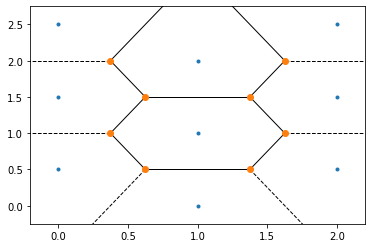

In [515]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

# points = t_ans.to_numpy()
points = np.array([ [0, 0.5], [0, 1.5], [0, 2.5], [1, 0], [1, 1], [1, 2],
                    [2, 0.5], [2, 1.5], [2, 2.5]])
vor = Voronoi(points, qhull_options='Qbb Qc Qx')
voronoi_plot_2d(vor)
plt.savefig("fname", dpi=100)
plt.show()


In [ ]:
h = np.array([])
for i, reg in enumerate(vor.regions):
    print(points[np.where(vor.point_region == i)[0][0]])
    loc = points[np.where(vor.point_region == i)[0][0]]
#     print(reg,'/n')
    if(np.any(np.array(reg) == -1)):
        reg.remove(-1)
    h1 = np.array([])
    for j in range(len(reg)):
#         print(vor.vertices[reg[j]])
        ver = vor.vertices[reg[j]]
        dist = np.linalg.norm(loc-ver)
        h1 = np.max(np.append(h1,[dist]))
#         print(g)
    h = np.append(h,h1)
    print(h1)
print(np.max(h))        

In [243]:
points = df.to_numpy()
vor = Voronoi(points, qhull_options='Qbb Qc Qx')

h = np.array([])
for i, reg in enumerate(vor.regions):
#     print(points[np.where(vor.point_region == i)[0][0]])
    loc = points[np.where(vor.point_region == i)[0][0]]
#     print(reg,'/n')
#     if(np.any(np.array(reg) == -1)):
#         reg.remove(-1)
    h1 = np.array([])
    for j in range(len(reg)):
#         print(vor.vertices[reg[j]])
        ver = vor.vertices[reg[j]]
        dist = np.linalg.norm(loc-ver)
        h1 = np.append(h1,[dist])
    h1 = np.max(h1)
#         print(g)
    h = np.append(h,h1)
#     print(h1)
print(np.max(h))   

1546734.6740296644


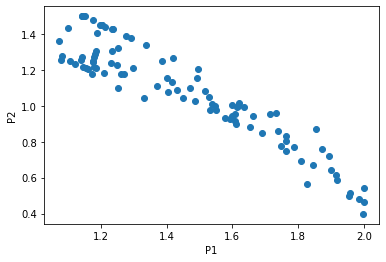

In [350]:
# vor = Voronoi(points, qhull_options='Qbb Qc Qx')
# voronoi_plot_2d(vor)
# plt.savefig("fname", dpi=100)
# plt.show()

plt.scatter(df['P1'].to_numpy(),df['P2'].to_numpy())
plt.ylabel('P2')
plt.xlabel('P1')
plt.savefig('P1vP2', dpi=500)

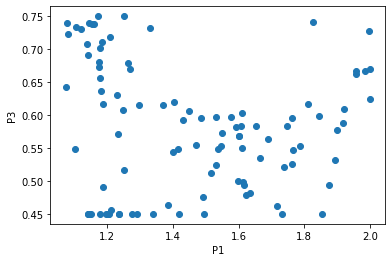

In [352]:
plt.scatter(df['P1'].to_numpy(),df['P3'].to_numpy())
plt.ylabel('P3')
plt.xlabel('P1')
plt.savefig('P1vP3', dpi=500)

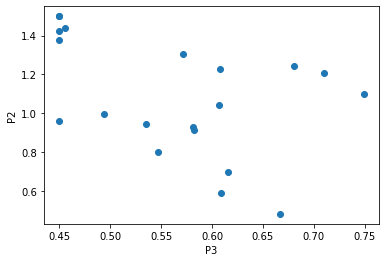

In [594]:
plt.scatter(df['P3'].to_numpy()[:20],df['P2'].to_numpy()[:20])
plt.ylabel('P2')
plt.xlabel('P3')
plt.savefig('P3vP2', dpi=500)

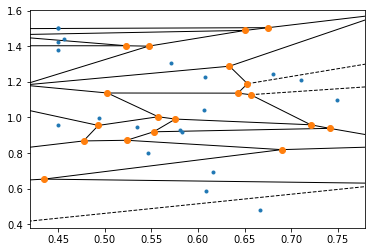

In [599]:
points = df[['P3','P2']].to_numpy()[:20]
vor = Voronoi(points,qhull_options='Qbb Qc Qx' )
fig = voronoi_plot_2d(vor)

plt.show()

In [600]:
vor.vertices

array([[ 1.21012218e+00,  7.23055857e-01],
       [ 5.47020459e-01,  1.40061786e+00],
       [ 7.97827337e-01,  1.58058144e+00],
       [ 8.46655537e-01,  8.43011329e-01],
       [ 8.12006601e-01,  6.28904614e-01],
       [-5.47642472e+05,  1.43986135e+00],
       [ 5.23202572e-01,  1.40294022e+00],
       [ 6.53156710e-01,  1.18950879e+00],
       [ 6.33857754e-01,  1.28804583e+00],
       [ 6.75545884e-01,  1.50460750e+00],
       [ 6.50782138e-01,  1.48922168e+00],
       [-1.35732280e+00,  1.46307874e+00],
       [ 3.82660762e-01,  1.46307877e+00],
       [-1.53380191e-01,  4.81483500e-01],
       [ 4.34969393e-01,  6.53520301e-01],
       [ 4.77312098e-01,  8.68049074e-01],
       [ 6.89790307e-01,  8.19179055e-01],
       [ 5.23658979e-01,  8.71801801e-01],
       [ 6.56450738e-01,  1.12803069e+00],
       [ 6.42806319e-01,  1.13662991e+00],
       [ 4.93132594e-01,  9.55134235e-01],
       [ 5.57407695e-01,  1.00400373e+00],
       [ 5.02940254e-01,  1.13740653e+00],
       [ 3.

In [603]:
points = df[['P3','P2']].to_numpy()[:20]
vor = Voronoi(points, furthest_site=False, qhull_options='Qbb Qc Qx')
# voronoi_plot_2d(vor)
# plt.savefig("fname", dpi=100)
# plt.show()

h = np.array([])
for i, reg in enumerate(vor.regions):
#     print(points[np.where(vor.point_region == i)[0][0]])
    loc = points[np.where(vor.point_region == i)[0][0]]
#     print(reg,'/n')
    if(np.any(np.array(reg) == -1)):
        reg.remove(-1)
    h1 = np.array([])
    for j in range(len(reg)):
#         print(vor.vertices[reg[j]])
        ver = vor.vertices[reg[j]]
        dist = np.linalg.norm(loc-ver)
        h1 = np.append(h1,[dist])
    h1 = np.max(h1)
#         print(g)
    h = np.append(h,h1)
#     print(h1)
print(np.max(h))  

547642.9220184798


In [592]:
h

array([5.94696662e-01, 3.57039541e-01, 1.80769988e+00, 5.47642922e+05,
       2.01071219e-01, 5.47642922e+05, 7.69961537e-01, 7.69961537e-01,
       5.94696662e-01, 9.89960173e-02, 2.55738559e-01, 7.69961537e-01,
       2.00649604e-01, 5.47642922e+05, 3.57039541e-01, 1.60387248e-01,
       9.57161370e-02, 2.73832494e-01, 1.42869362e-01, 5.94696662e-01])

In [406]:
for i in range(vor.vertices.shape[0]):
    if (np.any(vor.vertices[i] >= 3.0) | np.any(vor.vertices[i] <= -3.0)):
        print(vor.vertices[i])

[10.98549699 10.88506664 11.33085309]
[-11.25200824  -8.55179163  -7.83278931]


In [ ]:
loc = points[np.where(vor.point_region == 3)[0][0]]
h1 = np.array([])
reg = vor.regions[3]
for j in range(len(reg)):
    ver = vor.vertices[reg[j]]
    dist = np.linalg.norm(loc-ver)
    h1 = np.append(h1,[dist])
    print(vor.vertices[reg[j]])

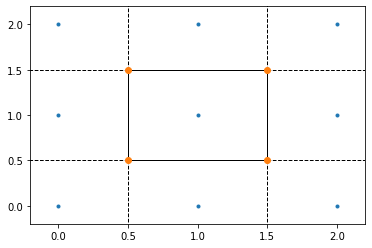

In [556]:
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])
vor = Voronoi(points,qhull_options='Qbb Qc Qx' )
fig = voronoi_plot_2d(vor)

plt.show()

In [559]:
h = np.array([])
for i, reg in enumerate(vor.regions):
#     print(points[np.where(vor.point_region == i)[0][0]])
    loc = points[np.where(vor.point_region == i)[0][0]]
    print(loc)
#     print(reg,'/n')
    if(np.any(np.array(reg) == -1)):
        reg.remove(-1)
    h1 = np.array([])
    for j in range(len(reg)):
#         print(vor.vertices[reg[j]])
        ver = vor.vertices[reg[j]]
        dist = np.linalg.norm(loc-ver)
        print(ver)
        print(dist)
        h1 = np.append(h1,[dist])
#     h1 = np.max(h1)
#         print(g)
    h = np.append(h,h1)
    print("/n")
#     print(h1)
print(np.max(h))  

[0 2]
[0.5 1.5]
0.7071067811865476
/n
[0 0]
[0.5 0.5]
0.7071067811865476
/n
[0 1]
[0.5 0.5]
0.7071067811865476
[0.5 1.5]
0.7071067811865476
/n
[2 1]
[1.5 1.5]
0.7071067811865476
[1.5 0.5]
0.7071067811865476
/n
[2 2]
[1.5 1.5]
0.7071067811865476
/n
[2 0]
[1.5 0.5]
0.7071067811865476
/n
[1 1]
[1.5 1.5]
0.7071067811865476
[1.5 0.5]
0.7071067811865476
[0.5 0.5]
0.7071067811865476
[0.5 1.5]
0.7071067811865476
/n
[1 0]
[1.5 0.5]
0.7071067811865476
[0.5 0.5]
0.7071067811865476
/n
[1 2]
[1.5 1.5]
0.7071067811865476
[0.5 1.5]
0.7071067811865476
/n
0.7071067811865476
